In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.display import display

%matplotlib inline 
np.random.seed(42)

## 1. Loading the Data 

In [360]:
housing = pd.read_csv('../data/train.csv')

housing = pd.DataFrame(housing)

housing = housing.set_index('Id')

housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. Exploratory Data Analysis (EDA)

### A. Data Types

In [361]:
housing['MSSubClass'] = housing['MSSubClass'].astype(object)

In [362]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null object
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

### B. Plotting histograms of the numeric columns. 

In [363]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']


numeric_cols = list((housing.select_dtypes(include=numerics)).columns)

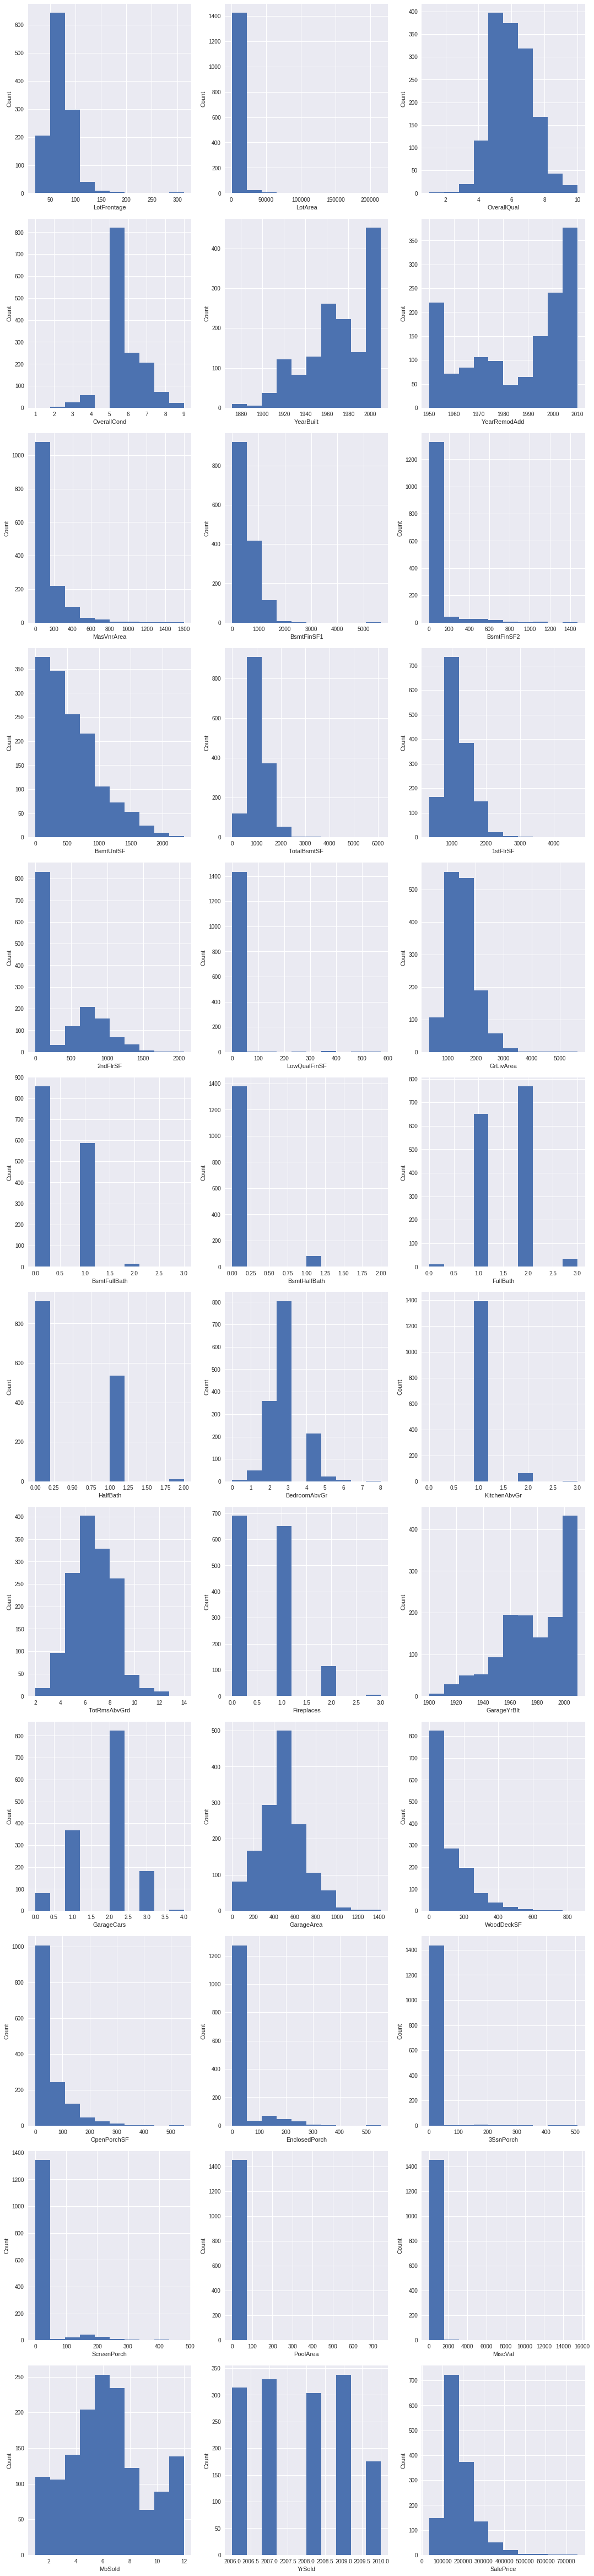

In [365]:
fig = plt.figure(figsize=(15,70))
for i, col in enumerate(numeric_cols):
    fig.add_subplot(13,3,i+1)
    housing[col].hist()
    plt.xlabel(col)
    plt.ylabel('Count')

fig.tight_layout()

#### Observations

Most distributions are skewed right, which makes sense for a lot of these house features. Most houses' metrics tend to fall on the smaller size since most houses are small rather than large. Only a small number of house reach high square footage in area for example.



### C. Plotting the Numeric Columns Against `SalePrice` using scatter plots.

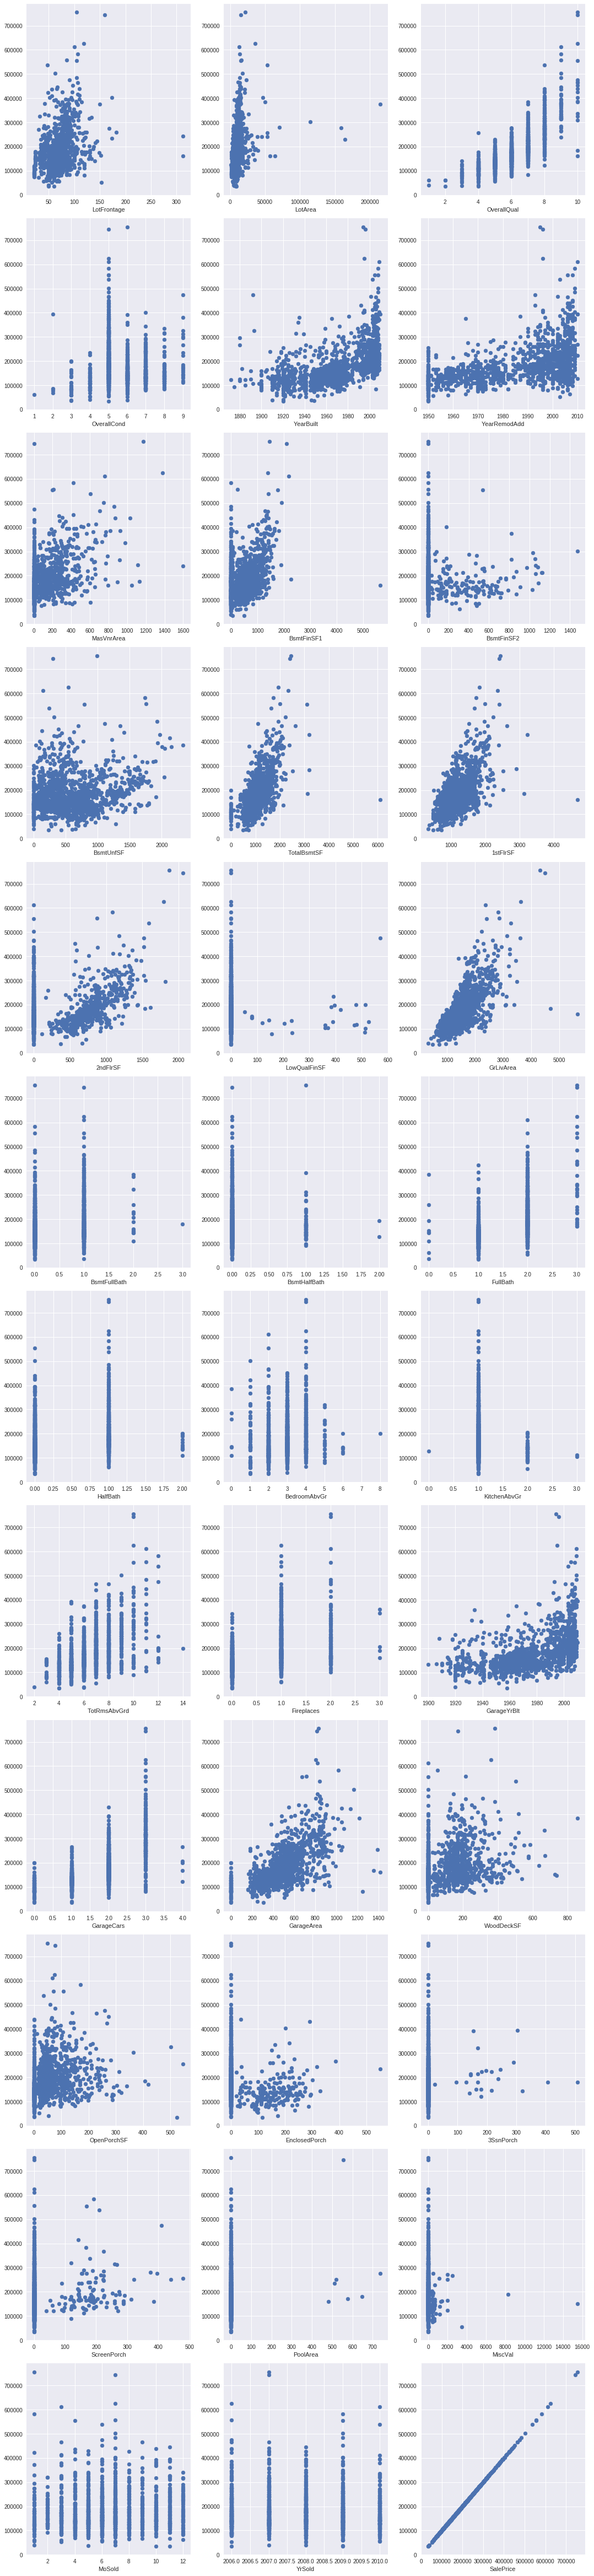

In [366]:
fig = plt.figure(figsize=(15,70))
for i, col in enumerate(numeric_cols):
    fig.add_subplot(13,3,i+1)
    plt.scatter(housing[col], housing['SalePrice'])
    plt.xlabel(col)

fig.tight_layout()

#### Observations

As expected, many variables have a positive linear relationship with Sale Price. For example, the newer the garage was built, the higher the Sale Price.



### D. Bar plots to plot categorical features against `SalePrice`

In [367]:
categorical_cols = housing.select_dtypes(exclude=numerics).columns

len(categorical_cols)

44

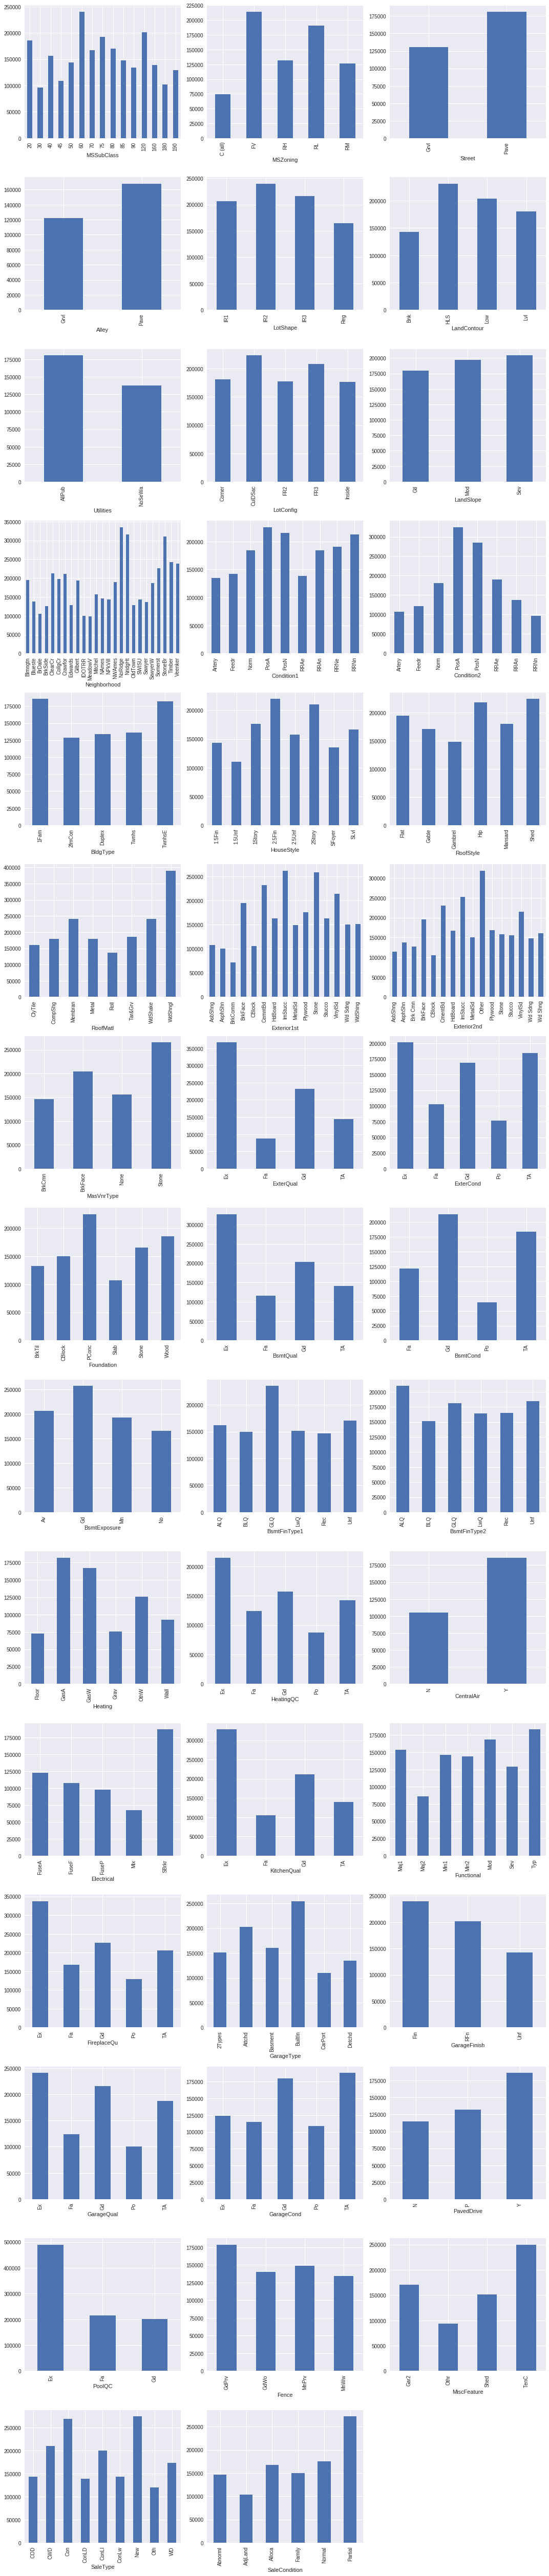

In [368]:
fig = plt.figure(figsize=(15,70))
for i, col in enumerate(categorical_cols):
    fig.add_subplot(15,3,i+1)
    housing.groupby(col)['SalePrice'].mean().plot.bar()
    plt.xlabel(col)

fig.tight_layout()

#### Observations

The plots make sense. Some categories are more obvious to see how they make sense, for example those measured with and Excellent, Good, Fair etc. scale. For these type of categories, we can see how Excellent scores have a higher mean Sale Price; the higher quality of a feature, the higher the price of the house.



## 3. Preprocessing

### A. Identifying and Removing Outliers for `SalePrice`

(array([ 148.,  723.,  373.,  135.,   51.,   19.,    4.,    3.,    2.,    2.]),
 array([  34900.,  106910.,  178920.,  250930.,  322940.,  394950.,
         466960.,  538970.,  610980.,  682990.,  755000.]),
 <a list of 10 Patch objects>)

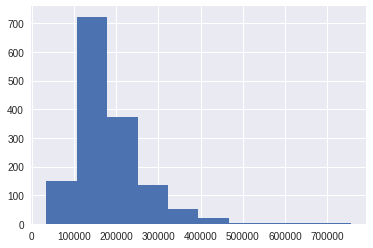

In [369]:
plt.hist(housing['SalePrice'])

In [370]:
1460/2

730/2

730 + 365

1095

In [371]:
sorted_sale_prices = np.array(housing['SalePrice'].sort_values(ascending=True))

Q1 = sorted_sale_prices[365]

Q3 = sorted_sale_prices[1095]

IQR = Q3 - Q1
IQR

84000

In [372]:
outlier_marker = Q3 + 3*IQR
outlier_marker

466000

In [373]:
without_outliers = (housing['SalePrice'] < 466000) == True

In [374]:
housing = housing[without_outliers]

(array([  28.,  245.,  462.,  328.,  172.,  104.,   54.,   27.,   18.,   10.]),
 array([  34900.,   77910.,  120920.,  163930.,  206940.,  249950.,
         292960.,  335970.,  378980.,  421990.,  465000.]),
 <a list of 10 Patch objects>)

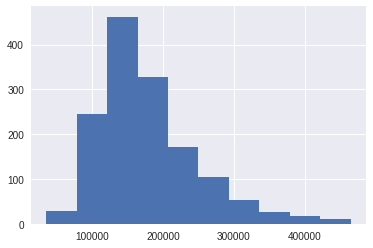

In [375]:
plt.hist(housing['SalePrice'])

Using Tukey's method to determine outliers with 1.5 times the interquartile range sets the considered data limit at 340,000. This seems too low of a delimeter to determine an outlier, it would mean leaving out 61 data points that could very well be necessary towards building a good model. Instead, I will use double that measure with 3 times the interquartile range, setting the considered data points limit at 466,000 which will only leave out 12 data points. Despite an obvious right skew, this is to be expected. Most houses tend to fall in the lesser expensive range - the mean is roughly around 150k-200k.

### B. Filling missing data

'LotFrontage' -- Nans are null ??

'Alley' -- Nans are NAs (no alley)

'MasVnrType' -- Nans are NAs (no masonry)

'MasVnrArea'-- Nans are null (no masonry)

'BsmtQual' -- Nans are NAs (no basement)

'BsmtCond' -- Nans are NAs (no basement)

'BsmtExposure' -- Nans are NAs (no basement)

'BsmtFinType1' -- Nans are NAs (no basement)

'BsmtFinType2' -- Nans are NAs (no basement)

'Electrical' -- Nans are null

'FireplaceQu' -- Nans are NAs (no fireplace)

'GarageType' -- Nans are NAs (no garage)

'GarageYrBlt' -- Nans are NAs (no garage)

'GarageFinish' -- Nans are NAs (no garage)

'GarageQual' -- Nans are NAs (no garage)

'GarageCond' -- Nans are NAs (no garage)

'PoolQC' -- Nans are NAs (no pool)

'Fence' -- Nans are NAs (no fence)

'MiscFeature' -- Nans are NAs (no misc feature)

In [376]:
cols_with_nulls = []

for col in housing.columns:
    if housing[col].isnull().sum() > 0:
        cols_with_nulls.append(col)
        
cols_with_nulls

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [377]:
sum_nulls_per_column = []

for col in cols_with_nulls:
    sum_nulls_per_column.append((col, housing[col].isnull().sum()))
    
sum_nulls_per_column

[('LotFrontage', 258),
 ('Alley', 1357),
 ('MasVnrType', 8),
 ('MasVnrArea', 8),
 ('BsmtQual', 37),
 ('BsmtCond', 37),
 ('BsmtExposure', 38),
 ('BsmtFinType1', 37),
 ('BsmtFinType2', 38),
 ('Electrical', 1),
 ('FireplaceQu', 690),
 ('GarageType', 81),
 ('GarageYrBlt', 81),
 ('GarageFinish', 81),
 ('GarageQual', 81),
 ('GarageCond', 81),
 ('PoolQC', 1442),
 ('Fence', 1169),
 ('MiscFeature', 1394)]

In [378]:
housing[cols_with_nulls].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1448 entries, 1 to 1460
Data columns (total 19 columns):
LotFrontage     1190 non-null float64
Alley           91 non-null object
MasVnrType      1440 non-null object
MasVnrArea      1440 non-null float64
BsmtQual        1411 non-null object
BsmtCond        1411 non-null object
BsmtExposure    1410 non-null object
BsmtFinType1    1411 non-null object
BsmtFinType2    1410 non-null object
Electrical      1447 non-null object
FireplaceQu     758 non-null object
GarageType      1367 non-null object
GarageYrBlt     1367 non-null float64
GarageFinish    1367 non-null object
GarageQual      1367 non-null object
GarageCond      1367 non-null object
PoolQC          6 non-null object
Fence           279 non-null object
MiscFeature     54 non-null object
dtypes: float64(3), object(16)
memory usage: 226.2+ KB


In [379]:
cat_cols_with_nulls = ['Alley','MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                       'BsmtFinType2','Electrical','FireplaceQu','GarageType','GarageFinish',
                       'GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

In [380]:
for col in cat_cols_with_nulls:
    mask = housing[col].isnull()
    housing[col] = housing[col].mask(mask, 'na')

In [381]:
lot_mask = housing['LotFrontage'].isnull()
housing['LotFrontage'] = housing['LotFrontage'].mask(lot_mask, housing['LotFrontage'].mean())

In [382]:
mas_mask = housing['MasVnrArea'].isnull()
housing['MasVnrArea'] = housing['MasVnrArea'].mask(mas_mask, 0)

In [383]:
grg_mask = housing['GarageYrBlt'].isnull()
housing['GarageYrBlt'] = housing['GarageYrBlt'].mask(grg_mask, housing['GarageYrBlt'].median())

In [384]:
housing.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC      

### C.  Dummy variables for categorical columns

In [385]:
housing = pd.get_dummies(housing, columns = categorical_cols)

In [386]:
housing.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth', 'SaleType_WD',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=319)

### D. Splitting data into a train and test set

In [387]:
from sklearn.model_selection import train_test_split

In [388]:
X = housing.drop('SalePrice', axis = 1)

In [389]:
y = housing['SalePrice']

In [390]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [391]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((970, 318), (478, 318), (970,), (478,))

We hold out a test set because we need to understand how our model performs on data it hasn't seen. We may create a model that fits our training data very well but does not score well on the test set, suggesting that it won't predict well given new data. With a test set, we can understand how our model performs on unseen data.

### E. Scaling the data

In [392]:
from sklearn.preprocessing import StandardScaler

In [393]:
scaler = StandardScaler()

In [394]:
scaler.fit(X_train, y_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [395]:
X_train_sc = pd.DataFrame(X_train_sc, columns= X.columns)

## 4. Modeling

### A. Benchmarking

As we get started with modeling we should have some basis for comparison to get a sense of what a "good" model is for this task. 

For this task, as we will be focusing on linear models, we will use the most naive of the linear models, the Linear Regression as our benchmark. 

In [396]:
from sklearn.linear_model import LinearRegression

In [399]:
results = list()

#### Raw Benchmark

In [400]:
benchmark_raw = LinearRegression()

In [401]:
benchmark_raw.fit(X_train, y_train)
raw_train_score = benchmark_raw.score(X_train, y_train)
raw_test_score = benchmark_raw.score(X_test, y_test)

results.append({'name':'benchmark',
                'model':benchmark_raw,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_train_score})
results.append({'name':'benchmark',
                'model':benchmark_raw,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_test_score})

#### Scaled Benchmark

In [402]:
benchmark_scaled = benchmark_raw.fit(X_train_sc, y_train)

scaled_train_score = benchmark_scaled.score(X_train, y_train)
scaled_test_score = benchmark_scaled.score(X_test, y_test)

results.append({'name':'benchmark',
                'model':benchmark_scaled,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_train_score})

results.append({'name':'benchmark',
                'model':benchmark_scaled,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_test_score})

In [431]:
results_df[results_df.name == 'benchmark'].sort_values('score', ascending=False)

,dataset,model,name,preprocessing,score
0,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,9.477583e-01
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,8.538106e-01
2,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-1.955989e+27
3,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-2.614477e+27


#### Observations

Linear Regression only performs well on raw data, and terribly poor on scaled data.


### B. Naive Regularization

Next, a series of fits using the three regularized linear regression models with their default settings.

I will perform each of these against both the raw and the scaled data. I will be fitting a total of six models.

- A naive Ridge Regression against the raw data
- A naive Lasso Regression against the raw data
- A naive ElasticNet Regression against the raw data
- A naive Ridge Regression against the scaled data
- A naive Lasso Regression against the scaled data
- A naive ElasticNet Regression against the scaled data

In [403]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [404]:
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()

raw_ridge = ridge.fit(X_train, y_train)
raw_lasso = lasso.fit(X_train, y_train)
raw_elastic = elastic.fit(X_train, y_train)

scaled_ridge = ridge.fit(X_train_sc, y_train)
scaled_lasso = lasso.fit(X_train_sc, y_train)
scaled_elastic = elastic.fit(X_train_sc, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [405]:
raw_ridge.score(X_train, y_train)

-4404480.2957790168

In [406]:
raw_ridge_train_score = raw_ridge.score(X_train, y_train)
raw_ridge_test_score = raw_ridge.score(X_test, y_test)

results.append({'name':'ridge',
                'model':raw_ridge,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_ridge_train_score})

results.append({'name':'ridge',
                'model':raw_ridge,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_ridge_test_score})


raw_lasso_train_score = raw_lasso.score(X_train, y_train)
raw_lasso_test_score = raw_lasso.score(X_test, y_test)

results.append({'name':'lasso',
                'model':raw_lasso,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_lasso_train_score})

results.append({'name':'lasso',
                'model':raw_lasso,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_lasso_test_score})


raw_elastic_train_score = raw_elastic.score(X_train, y_train)
raw_elastic_test_score = raw_elastic.score(X_test, y_test)

results.append({'name':'elastic',
                'model':raw_elastic,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_elastic_train_score})

results.append({'name':'elastic',
                'model':raw_elastic,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_elastic_test_score})


scaled_ridge_train_score = scaled_ridge.score(X_train_sc, y_train)
scaled_ridge_test_score = scaled_ridge.score(X_test_sc, y_test)

results.append({'name':'ridge',
                'model':scaled_ridge,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_ridge_train_score})

results.append({'name':'ridge',
                'model':scaled_ridge,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_ridge_test_score})



scaled_lasso_train_score = scaled_lasso.score(X_train_sc, y_train)
scaled_lasso_test_score = scaled_lasso.score(X_test_sc, y_test)

results.append({'name':'lasso',
                'model':scaled_lasso,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_lasso_train_score})

results.append({'name':'lasso',
                'model':scaled_lasso,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_lasso_test_score})


scaled_elastic_train_score = scaled_elastic.score(X_train_sc, y_train)
scaled_elastic_test_score = scaled_elastic.score(X_test_sc, y_test)

results.append({'name':'elastic',
                'model':scaled_elastic,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_elastic_train_score})

results.append({'name':'elastic',
                'model':scaled_elastic,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_elastic_test_score})

In [407]:
results_df = pd.DataFrame(results)

In [408]:
results_df

,dataset,model,name,preprocessing,score
0,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,9.477583e-01
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,8.538106e-01
2,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-1.955989e+27
3,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-2.614477e+27
4,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,raw,-4.404480e+06
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,raw,-5.632141e+06
6,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,raw,-4.261545e+06
7,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,raw,-5.433244e+06
8,train,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",elastic,raw,-1.018487e+06
9,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",elastic,raw,-1.303620e+06


In [409]:
results_df[(results_df.preprocessing == 'raw') & 
           (results_df.dataset == 'test')]

,dataset,model,name,preprocessing,score
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,8.538106e-01
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,raw,-5.632141e+06
7,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,raw,-5.433244e+06
9,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",elastic,raw,-1.303620e+06


#### Observations

The only well performing model on raw data is the benchmark linear regression.



#### Scaled test results

In [426]:
results_df[(results_df.preprocessing == 'scaled') & 
           (results_df.dataset == 'test')].sort_values('score', ascending=False)

,dataset,model,name,preprocessing,score
15,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",elastic,scaled,8.711608e-01
11,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,scaled,8.544851e-01
13,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,scaled,8.541785e-01
3,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-2.614477e+27


#### Observations

We can immediately see the benefits of running our models on scaled data. The benchmark linear regression model has fallen down to the last position and it's score is tremendously bad. Elastic, Ridge and Lasso are all performing quite well with R^2 scores above .85


#### Benchmark models

In [427]:
results_df[results_df.name == 'benchmark'].sort_values('score', ascending=False)

,dataset,model,name,preprocessing,score
0,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,9.477583e-01
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,8.538106e-01
2,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-1.955989e+27
3,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,scaled,-2.614477e+27


#### Ridge models

In [428]:
results_df[results_df.name == 'ridge'].sort_values('score', ascending=False)

,dataset,model,name,preprocessing,score
10,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,scaled,9.477455e-01
11,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,scaled,8.544851e-01
4,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,raw,-4.404480e+06
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",ridge,raw,-5.632141e+06


#### Lasso models

In [429]:
results_df[results_df.name == 'lasso'].sort_values('score', ascending=False)

,dataset,model,name,preprocessing,score
12,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,scaled,9.477574e-01
13,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,scaled,8.541785e-01
6,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,raw,-4.261545e+06
7,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",lasso,raw,-5.433244e+06


#### Elasticnet models

In [430]:
results_df[results_df.name == 'elastic'].sort_values('score', ascending=False)

,dataset,model,name,preprocessing,score
14,train,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",elastic,scaled,9.222232e-01
15,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",elastic,scaled,8.711608e-01
8,train,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",elastic,raw,-1.018487e+06
9,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",elastic,raw,-1.303620e+06


#### Observations

Scaled train and test data sets perform **much** better than raw. 



### C. Cross-validated models

In [415]:
cv_results = list()

In [416]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

In [417]:
alphas = np.logspace(-2, 4, 7)

ridgeCV = RidgeCV(alphas = alphas)
lassoCV = LassoCV(alphas = alphas)
elasticCV = ElasticNetCV(alphas = alphas)

raw_ridgeCV = ridgeCV.fit(X_train, y_train)
raw_lassoCV = lassoCV.fit(X_train, y_train)
raw_elasticCV = elasticCV.fit(X_train, y_train)

scaled_ridgeCV = ridgeCV.fit(X_train_sc, y_train)
scaled_lassoCV = lassoCV.fit(X_train_sc, y_train)
scaled_elasticCV = elasticCV.fit(X_train_sc, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [418]:
raw_ridgeCV_train_score = raw_ridgeCV.score(X_train, y_train)
raw_ridgeCV_test_score = raw_ridgeCV.score(X_test, y_test)

cv_results.append({'name':'ridgeCV',
                'model':raw_ridgeCV,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_ridgeCV_train_score})

cv_results.append({'name':'ridgeCV',
                'model':raw_ridgeCV,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_ridgeCV_test_score})


raw_lassoCV_train_score = raw_lassoCV.score(X_train, y_train)
raw_lassoCV_test_score = raw_lassoCV.score(X_test, y_test)

cv_results.append({'name':'lassoCV',
                'model':raw_lassoCV,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_lassoCV_train_score})

cv_results.append({'name':'lassoCV',
                'model':raw_lassoCV,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_lassoCV_test_score})


raw_elasticCV_train_score = raw_elasticCV.score(X_train, y_train)
raw_elasticCV_test_score = raw_elasticCV.score(X_test, y_test)

cv_results.append({'name':'elasticCV',
                'model':raw_elasticCV,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_elasticCV_train_score})

cv_results.append({'name':'elasticCV',
                'model':raw_elasticCV,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_elasticCV_test_score})


scaled_ridgeCV_train_score = scaled_ridgeCV.score(X_train_sc, y_train)
scaled_ridgeCV_test_score = scaled_ridgeCV.score(X_test_sc, y_test)

cv_results.append({'name':'ridgeCV',
                'model':scaled_ridgeCV,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_ridgeCV_train_score})

cv_results.append({'name':'ridgeCV',
                'model':scaled_ridgeCV,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_ridgeCV_test_score})



scaled_lassoCV_train_score = scaled_lassoCV.score(X_train_sc, y_train)
scaled_lassoCV_test_score = scaled_lassoCV.score(X_test_sc, y_test)

cv_results.append({'name':'lassoCV',
                'model':scaled_lassoCV,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_lassoCV_train_score})

cv_results.append({'name':'lassoCV',
                'model':scaled_lassoCV,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_lassoCV_test_score})


scaled_elasticCV_train_score = scaled_elasticCV.score(X_train_sc, y_train)
scaled_elasticCV_test_score = scaled_elasticCV.score(X_test_sc, y_test)

cv_results.append({'name':'elasticCV',
                'model':scaled_elasticCV,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_elasticCV_train_score})

cv_results.append({'name':'elasticCV',
                'model':scaled_elasticCV,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_elasticCV_test_score})

#### Raw test results

In [419]:
cv_results_df = pd.DataFrame(cv_results)

In [420]:
cv_results_df[(cv_results_df.dataset == 'test') & (cv_results_df.preprocessing == 'raw')]

,dataset,model,name,preprocessing,score
1,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridgeCV,raw,-8.943979e+05
3,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lassoCV,raw,-3.514331e+06
5,test,"ElasticNetCV(alphas=array([ 1.00000e-02, 1....",elasticCV,raw,-1.303620e+06


#### Scaled test results

In [421]:
cv_results_df[(cv_results_df.dataset == 'test') & (cv_results_df.preprocessing == 'scaled')]

,dataset,model,name,preprocessing,score
7,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridgeCV,scaled,0.862504
9,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lassoCV,scaled,0.875124
11,test,"ElasticNetCV(alphas=array([ 1.00000e-02, 1....",elasticCV,scaled,0.871161


### D. Model Selection

In [422]:
cv_results_df.sort_values(by = 'score', ascending = False)

,dataset,model,name,preprocessing,score
8,train,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lassoCV,scaled,9.287469e-01
10,train,"ElasticNetCV(alphas=array([ 1.00000e-02, 1....",elasticCV,scaled,9.222232e-01
6,train,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridgeCV,scaled,9.016533e-01
9,test,"LassoCV(alphas=array([ 1.00000e-02, 1.00000...",lassoCV,scaled,8.751241e-01
11,test,"ElasticNetCV(alphas=array([ 1.00000e-02, 1....",elasticCV,scaled,8.711608e-01
7,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridgeCV,scaled,8.625040e-01
0,train,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridgeCV,raw,-6.928989e+05
1,test,"RidgeCV(alphas=array([ 1.00000e-02, 1.00000...",ridgeCV,raw,-8.943979e+05
4,train,"ElasticNetCV(alphas=array([ 1.00000e-02, 1....",elasticCV,raw,-1.018487e+06
5,test,"ElasticNetCV(alphas=array([ 1.00000e-02, 1....",elasticCV,raw,-1.303620e+06


The top three performing models are:

- `scaled_lassoCV()`
- `scaled_elasticCV()`
- `scaled_ridgeCV()`

## Bias / variance tradeoff

Why do regularized models perform better on the test set?

The regularized models perform better because the coefficients have adjusted to values that have small enough weights to fit the training data, but not big enough that it would overfit the data. By doing this, once new data is introduced to the model (i.e. test data), we can be confident that the model will also fit this new data, much better than it would were we fitting on an un-regularized model. 

### Interpreting coefficients

In [423]:
def plot_coef(model, top_n = 10):
    '''
    Plots the magnitude of top and bottom n coefficients
    '''
    cols = X_train.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
    bottom_10 = pd.DataFrame(zipped).tail(top_n)
    return pd.concat([top_10, bottom_10], axis=0).plot.barh(x = 0, y = 1)

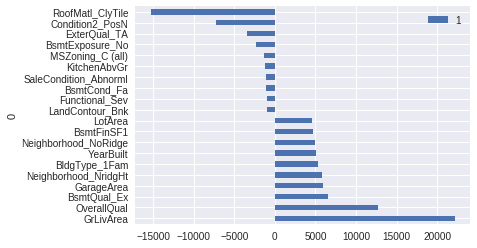

In [425]:
plot_coef(scaled_lassoCV)

#### Which features add / take away most value from a home?

Add:
- GrLivArea: Above grade (ground) living area square feet
- OverallQual: Rates the overall material and finish of the house
- BsmtQual_Ex: Evaluates the height of the basement (Excellent)

Take away:
- RoofMatl_ClyTile: Roof material (Clay or Tile)
- Condition2_PosN: Near positive off-site feature--park, greenbelt, etc.